# ![](https://www.gitbook.com/cdn-cgi/image/width=40,height=40,fit=contain,dpr=1.25,format=auto/https%3A%2F%2F2454584560-files.gitbook.io%2F~%2Ffiles%2Fv0%2Fb%2Fgitbook-28427.appspot.com%2Fo%2Fspaces%252F-LD4FEpEuXG2BKuShFdL%252Favatar.png%3Fgeneration%3D1526949040265200%26alt%3Dmedia) angr

Briefly, it is a multi-architecture binary analysis toolkit with Python API.
It allows you to perform:

- dynamic symbolic execution
- dependency analysis
- recovery of control-flow graph
- function identifier recovery
- exploitation / vulnerability discovery (including fuzzing)

## Simple binary

In [106]:
!echo 'abcd' | './binaries/simple'
!echo -e '\n------------'
!readelf -l 'binaries/simple'

Nice try!
------------

Elf file type is DYN (Shared object file)
Entry point 0x10c0
There are 13 program headers, starting at offset 64

Program Headers:
  Type           Offset             VirtAddr           PhysAddr
                 FileSiz            MemSiz              Flags  Align
  PHDR           0x0000000000000040 0x0000000000000040 0x0000000000000040
                 0x00000000000002d8 0x00000000000002d8  R      0x8
  INTERP         0x0000000000000318 0x0000000000000318 0x0000000000000318
                 0x000000000000001c 0x000000000000001c  R      0x1
      [Requesting program interpreter: /lib64/ld-linux-x86-64.so.2]
  LOAD           0x0000000000000000 0x0000000000000000 0x0000000000000000
                 0x00000000000006a8 0x00000000000006a8  R      0x1000
  LOAD           0x0000000000001000 0x0000000000001000 0x0000000000001000
                 0x00000000000002b5 0x00000000000002b5  R E    0x1000
  LOAD           0x0000000000002000 0x0000000000002000 0x0000000000002000


### Loading a binary file

In [107]:
import angr
import monkeyhex
import itertools
from IPython.display import display

base_addr = 0

project = angr.Project('binaries/simple', main_opts={'base_addr': base_addr})
project.loader

<Loaded simple, maps [0x0:0x607fff]>

In [69]:
print('Architecture & Entry')
display(project.arch)
display(project.entry)
display(project.filename)

print('All ELF objects')
display(project.loader.all_elf_objects)

print('Main object')
display(project.loader.main_object)

print('Shared objects')
display(project.loader.shared_objects)

print('Addresses')
display(project.loader.min_addr)
display(project.loader.max_addr)
display(project.loader.find_symbol('_start'))
display(project.loader.find_symbol('main'))
display(list(itertools.islice(project.loader.symbols, 15)))

Architecture & Entry


<Arch AMD64 (LE)>

0x4010c0

'binaries/simple'

All ELF objects


[<ELF Object simple, maps [0x400000:0x404017]>]

Main object


<ELF Object simple, maps [0x400000:0x404017]>

Shared objects


OrderedDict([('simple', <ELF Object simple, maps [0x400000:0x404017]>),
             ('extern-address space',
              <ExternObject Object cle##externs, maps [0x600000:0x607fff]>),
             ('cle##tls',
              <ELFTLSObjectV2 Object cle##tls, maps [0x700000:0x71500f]>)])

Addresses


0x400000

0x807fff

<Symbol "_start" in simple at 0x4010c0>

<Symbol "main" in simple at 0x4011a9>

[<Symbol "" in simple at 0x400000>,
 <Symbol "_ITM_deregisterTMCloneTable" in simple (import)>,
 <Symbol "printf" in simple (import)>,
 <Symbol "__libc_start_main" in simple (import)>,
 <Symbol "strcmp" in simple (import)>,
 <Symbol "__gmon_start__" in simple (import)>,
 <Symbol "gets" in simple (import)>,
 <Symbol "exit" in simple (import)>,
 <Symbol "_ITM_registerTMCloneTable" in simple (import)>,
 <Symbol "__cxa_finalize" in simple (import)>,
 <Symbol "" in simple at 0x400000>,
 <Symbol "" in simple at 0x400000>,
 <Symbol "crtstuff.c" in simple at 0x400000>,
 <Symbol "simple.c" in simple at 0x400000>,
 <Symbol "crtstuff.c" in simple at 0x400000>]

### Getting a disassembled block of code

In [41]:
from cle.backends.elf.symbol import ELFSymbol

main_symbol: ELFSymbol = project.loader.find_symbol('main')
project.factory.block(main_symbol.rebased_addr).pp()

        main:
4011a9  endbr64 
4011ad  push    rbp
4011ae  mov     rbp, rsp
4011b1  sub     rsp, 0x20
4011b5  mov     rax, qword ptr  fs:[0x28]
4011be  mov     qword ptr [rbp-0x8], rax
4011c2  xor     eax, eax
4011c4  lea     rax, [rbp-0x20]
4011c8  mov     rdi, rax
4011cb  mov     eax, 0x0
4011d0  call    gets


### Control-flow graph

As this binary is really small, it makes little difference when we autoload external symbols.
In real world it makes big difference - remember to pass `load_options={'auto_load_libs': False}` to `Project` constructor.

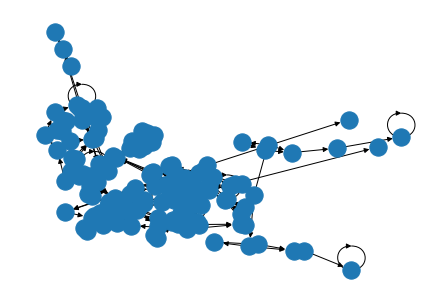

In [57]:
import networkx as nx
import matplotlib.pyplot as plt

start_symbol = project.loader.find_symbol('_start')

cfg = project.analyses.CFGEmulated(starts=[start_symbol.rebased_addr])
program_graph = cfg.graph

nx.draw(program_graph)
plt.show()

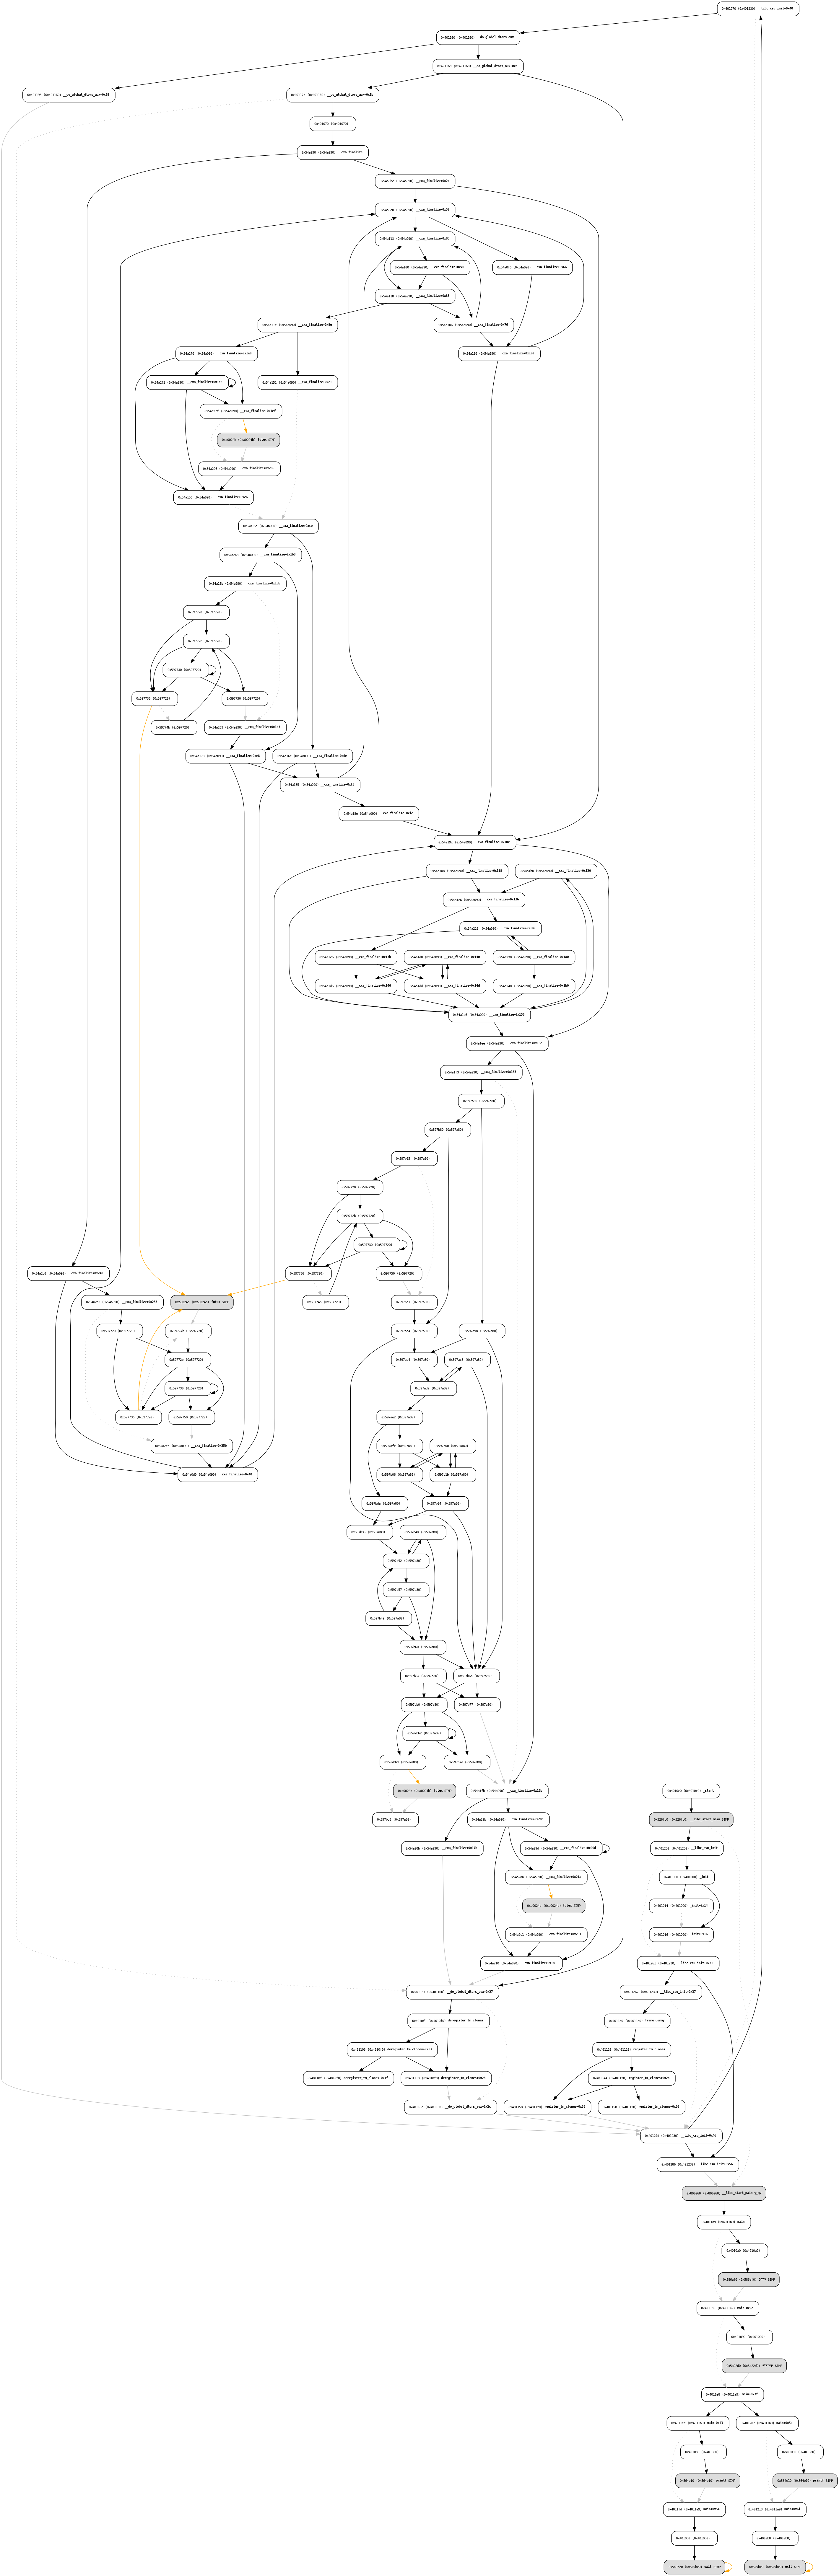

In [59]:
from IPython.core.display import Image
from angrutils import plot_cfg

plot_cfg(cfg, 'images/_start', asminst=True, remove_imports=True, remove_path_terminator=True)
display(Image('images/_start.png'))

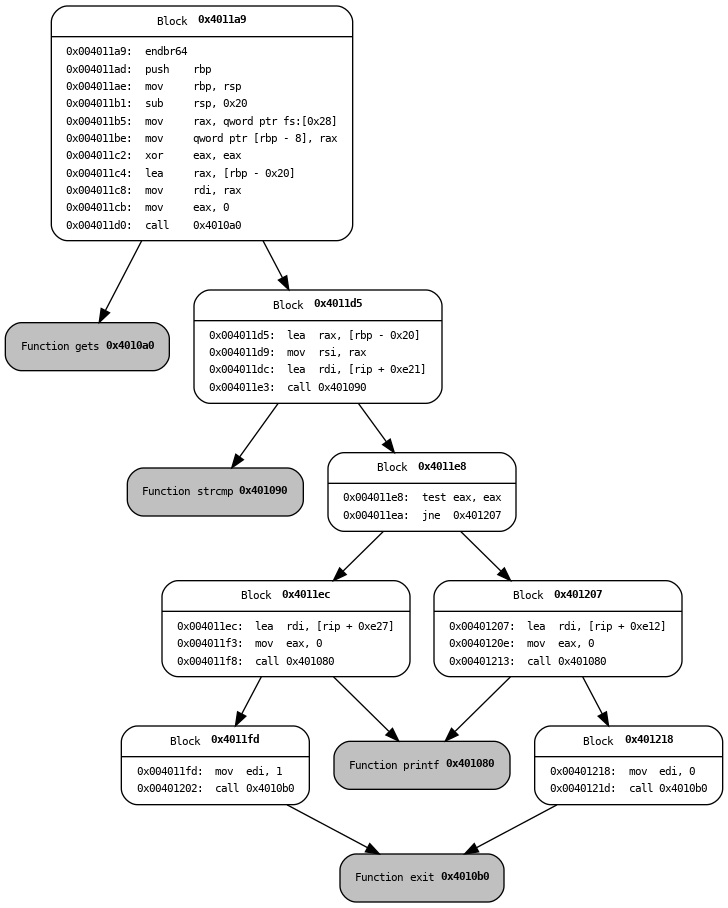

In [77]:
from angrutils import plot_func_graph

main_function = project.kb.functions.get('main')
plot_func_graph(project, main_function.transition_graph, f'images/{main_function.name}', asminst=True, vexinst=False)
display(Image(f'images/{main_function.name}.png'))

### Symbolic execution

In [114]:
import claripy as cp

sym_input = [cp.BVS('user_input', 8 * 64)]
flag = cp.Concat(*sym_input + [cp.BVV(b'\n')])

state = project.factory.full_init_state(
    args=['./simple'],
    add_options=angr.options.unicorn,
    stdin=flag
)

sim_manager = project.factory.simulation_manager(state)
sim_manager.run()

result = []
for x in sim_manager.deadended:
    if not b'Nice try!' in x.posix.dumps(1):
        result.append(x)

result[0].posix.dumps(0)

WARNING | 2022-01-21 19:20:49,536 | angr.simos.simos | stdin is constrained to 65 bytes (has_end=True). If you are only providing the first 65 bytes instead of the entire stdin, please use stdin=SimFileStream(name='stdin', content=your_first_n_bytes, has_end=False).
WARNING | 2022-01-21 19:20:50,042 | angr.storage.memory_mixins.default_filler_mixin | Filling memory at 0x7fffffffffeff8c with 4 unconstrained bytes referenced from 0x10c9 (_start+0x9 in simple (0x10c9))


b'DONE!'
b'Nice try!'


b'effective_python_angr\x00\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xb5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\xf5\n'

#### ...more optimal approach if we now the size and ranges

In [124]:
sym_input = [cp.BVS(f'user_input_{i}', 8) for i in range(21)]
flag = cp.Concat(*sym_input + [cp.BVV(b'\x00')])

state = project.factory.full_init_state(
    args=['./simple'],
    add_options=angr.options.unicorn,
    stdin=flag
)

sim_manager = project.factory.simulation_manager(state)
sim_manager.run()

for char in sym_input:
    state.solver.add(char < ord('{'))
    state.solver.add(char > ord('@'))

result = []
for x in sim_manager.deadended:
    if not b'Nice try!' in x.posix.dumps(1):
        result.append(x)

valid_input = result[0].posix.dumps(0)
''.join([chr(x) for x in valid_input[:-1]])

WARNING | 2022-01-21 19:23:52,398 | angr.simos.simos | stdin is constrained to 22 bytes (has_end=True). If you are only providing the first 22 bytes instead of the entire stdin, please use stdin=SimFileStream(name='stdin', content=your_first_n_bytes, has_end=False).
WARNING | 2022-01-21 19:23:52,764 | angr.storage.memory_mixins.default_filler_mixin | Filling memory at 0x7fffffffffeff8c with 4 unconstrained bytes referenced from 0x10c9 (_start+0x9 in simple (0x10c9))


'effective_python_angr'

#### More on Claripy solvers

Claripy library is used for symbolic execution. We can do various things with it:

In [204]:
solver = cp.Solver()
x = cp.BVS('x', 64)
y = cp.BVS('y', 64)

solver.add(4 * x == 10 * y)
solver.add(y == 10)
solver.add(x > 25)

print([num for num in solver.eval(x, 10)])


[9223372036854775833, 13835058055282163737, 4611686018427387929]
